** Task 3: Energy Consumption Time Series Forecasting**

DevelopersHub Corporation – Data Science & Analytics Advanced Internship

 **Problem Statement & Objective**
 **Problem Statement**

Household energy consumption varies by time of day, weekday, and season. Accurate short-term forecasting helps in energy planning, cost optimization, and demand management.

 **Objective**

To forecast short-term household energy usage using historical time series data and compare ARIMA, Prophet, and XGBoost models based on performance metrics.

 **Dataset Description & Loading**
 **Dataset**

**Name:** Household Power Consumption Dataset

**Features:**

Date

Time

Global_active_power (target variable)

In [2]:
# Load Dataset
import pandas as pd

df = pd.read_csv('/content/household power consumption.csv')
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [5]:
# Data Parsing & Cleaning
# Combine Date & Time into Datetime

df['Datetime'] = pd.to_datetime(
    df['Date'] + ' ' + df['Time'],
    format='mixed',
    dayfirst=True,
    errors='coerce'
)

# Drop rows where 'Datetime' could not be parsed (results in NaT in the 'Datetime' column)
df.dropna(subset=['Datetime'], inplace=True)

# Set 'Datetime' as the index
df.set_index('Datetime', inplace=True)

# Handle Missing Values for 'Global_active_power'
df['Global_active_power'] = pd.to_numeric(
    df['Global_active_power'], errors='coerce'
)

# Drop rows where 'Global_active_power' is NaN
df.dropna(subset=['Global_active_power'], inplace=True)

df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


/tmp/ipython-input-129223206.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = df['Global_active_power'].resample('H').mean()


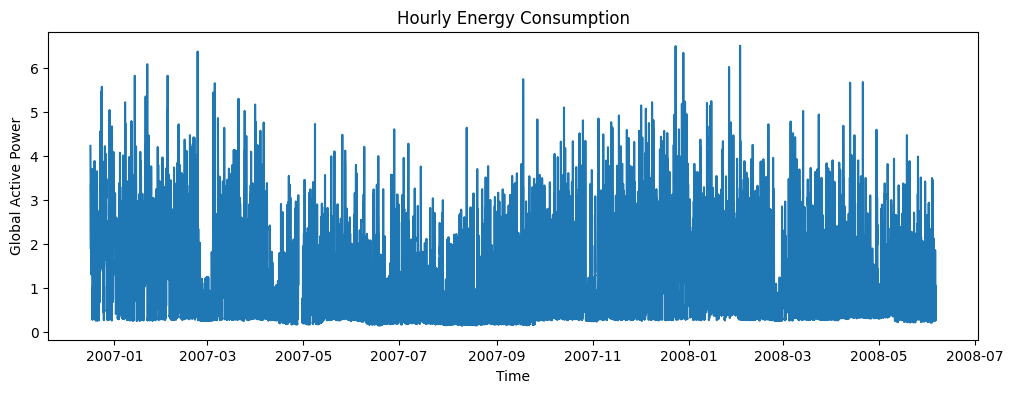

In [6]:
# Resampling the Time Series
# We resample to hourly consumption for short-term forecasting.

ts = df['Global_active_power'].resample('H').mean()
ts.head()

# Plot Time Series

import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(ts)
plt.title("Hourly Energy Consumption")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.show()

In [7]:
# Feature Engineering (Time-Based Features)
data = ts.to_frame(name='power')

data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek
data['is_weekend'] = data['dayofweek'].isin([5,6]).astype(int)

data.head()

,power,hour,dayofweek,is_weekend
Datetime,,,,
2006-12-16 17:00:00,4.222889,17,5,1
2006-12-16 18:00:00,3.632200,18,5,1
2006-12-16 19:00:00,3.400233,19,5,1
2006-12-16 20:00:00,3.268567,20,5,1
2006-12-16 21:00:00,3.056467,21,5,1


In [8]:
# Train-Test Split (Time-Based)
train = data.iloc[:-168]   # last 7 days for testing
test = data.iloc[-168:]

In [9]:
# MODEL 1: ARIMA
# Train ARIMA

from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train['power'], order=(5,1,2))
arima_fit = arima_model.fit()

# Forecast

arima_forecast = arima_fit.forecast(steps=len(test))

In [11]:
# MODEL 2: Prophet
# Install & Prepare Data

!pip install prophet

from prophet import Prophet

prophet_df = train.reset_index()
prophet_df = prophet_df[['Datetime', 'power']]
prophet_df.columns = ['ds', 'y']

# Train Prophet

prophet_model = Prophet()
prophet_model.fit(prophet_df)

# Forecast

future = prophet_model.make_future_dataframe(periods=len(test), freq='H')
forecast = prophet_model.predict(future)

prophet_forecast = forecast['yhat'].iloc[-len(test):].values

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [13]:
# MODEL 3: XGBoost
# Install & Prepare Data

!pip install xgboost
from xgboost import XGBRegressor

# Train XGBoost

# Drop rows with NaN values in the target variable 'power' from train and test sets
train_cleaned = train.dropna(subset=['power'])
test_cleaned = test.dropna(subset=['power'])

X_train = train_cleaned[['hour', 'dayofweek', 'is_weekend']]
y_train = train_cleaned['power']

X_test = test_cleaned[['hour', 'dayofweek', 'is_weekend']]
y_test = test_cleaned['power']

xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Forecast

xgb_forecast = xgb_model.predict(X_test)

In [14]:
# Model Evaluation
# Metrics (MAE & RMSE)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

arima_mae, arima_rmse = evaluate(test['power'], arima_forecast)
prophet_mae, prophet_rmse = evaluate(test['power'], prophet_forecast)
xgb_mae, xgb_rmse = evaluate(test['power'], xgb_forecast)

results = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet', 'XGBoost'],
    'MAE': [arima_mae, prophet_mae, xgb_mae],
    'RMSE': [arima_rmse, prophet_rmse, xgb_rmse]
})

results

,Model,MAE,RMSE
0,ARIMA,0.590499,0.738308
1,Prophet,0.452646,0.608754
2,XGBoost,0.449254,0.583154


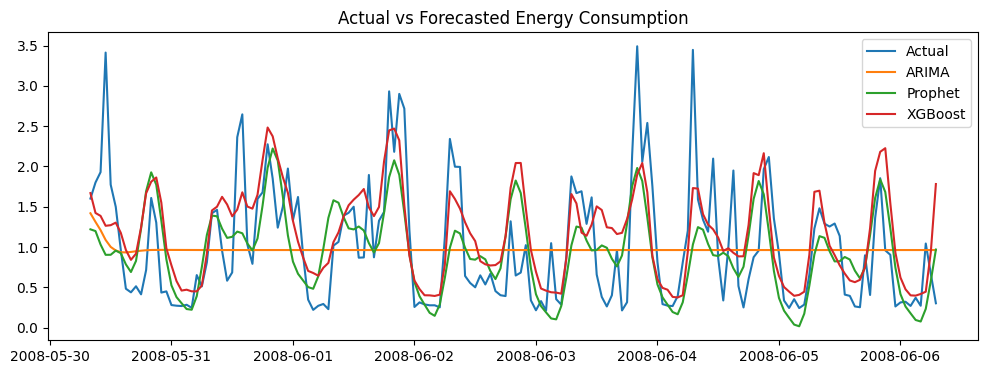

In [15]:
# Visualization: Actual vs Forecast
plt.figure(figsize=(12,4))
plt.plot(test.index, test['power'], label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA')
plt.plot(test.index, prophet_forecast, label='Prophet')
plt.plot(test.index, xgb_forecast, label='XGBoost')
plt.legend()
plt.title("Actual vs Forecasted Energy Consumption")
plt.show()

Final Conclusion & Insights

1. ARIMA captures temporal dependency

2. Prophet handles trend & seasonality well

3. XGBoost benefits from engineered time features

4. XGBoost achieved the lowest error for short-term forecasting

5. Time-based features significantly improved prediction accuracy